In [1]:
import sys
import tensorflow as tf
sys.path.append("/visuworks/Blindless_AIFFELTON/Ablation Study/")

# import customized modules
import preprocess, data_generator, check_result, metrics, loss, train

sys.path.append("/visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet")
import sd_unet

# Insert Path
# {model_name}_{epoch}ep_{model_inpusize}_{Generator | aG/fG/sG}
FILE_NAME = 'sd_unet_30ep_1024_fG_wo_decay'
INPUT_SHAPE = (1024, 1024, 1)
MODEL_PATH = "/visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/" + FILE_NAME + ".tf"
HISTORY_PATH = "/visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/history/" + FILE_NAME + '_history' ".json"

TRAIN_SOURCE = '/visuworks/Dataset/Selected Dataset 3/Train'
TEST_SOURCE = '/visuworks/Dataset/Selected Dataset 3/Test'

2024-01-31 06:41:19.378219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 06:41:19.378246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 06:41:19.379333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 06:41:19.384741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 06:41:19.961994: W tensorflow/compiler/tf2

In [3]:
# Define custom objects for loading the model
custom_objects = {'DiceLoss': loss.DiceLoss(), 
                  'sensitivity': metrics.sensitivity,
                  'specificity': metrics.specificity,
                  'accuracy' : metrics.accuracy,
                  'DropBlock2D': sd_unet.DropBlock2D}

# Create augmentation
train_preproc = preprocess.build_augmentation_for_general(INPUT_SHAPE[0], INPUT_SHAPE[0])
test_preproc = preprocess.build_augmentation_for_general(INPUT_SHAPE[0], INPUT_SHAPE[0],is_train=False)

# Create train, test generator
train_generator = data_generator.FullSizedDataGenerator(
    TRAIN_SOURCE, 
    batch_size=2, 
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    is_train=True,
    augmentation= train_preproc
)

test_generator = data_generator.FullSizedDataGenerator(
    TRAIN_SOURCE, 
    batch_size=2, 
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    is_train=False,
    augmentation= test_preproc
)

# Create model
model = sd_unet.SD_UNet(INPUT_SHAPE)
model.summary()

2024-01-31 05:35:23.118970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 05:35:23.153172: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 05:35:23.153389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 8)        80        ['input_1[0][0]']             
                                                                                                  
 drop_block2d (DropBlock2D)  (None, 1024, 1024, 8)        2097152   ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 8)        0         ['drop_block2d[0][0]']        
                                                                                              

In [4]:
train.model_train(model,
                  epoch = 30,
                  train_generator = train_generator,
                  test_generator = test_generator,
                  model_path = MODEL_PATH,
                  history_path = HISTORY_PATH,
                  save_every_epoch=True,
                  apply_weight_decay=False)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
2024-01-31 05:35:40.756672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-31 05:35:42.981767: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f582cc5eaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 05:35:42.981786: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-01-31 05:35:42.985132: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706679343.058640  980621 device_compiler.h:186] Compil

440/440 [==============================] - ETA: 0s - loss: 0.6469 - sensitivity: 0.1354 - specificity: 0.9840 - accuracy: 0.9242

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/1--0.6469-0.1354-0.9840-0.2645-0.9929.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/1--0.6469-0.1354-0.9840-0.2645-0.9929.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/1--0.6469-0.1354-0.9840-0.2645-0.9929.pb
440/440 [==============================] - 134s 273ms/step - loss: 0.6469 - sensitivity: 0.1354 - specificity: 0.9840 - accuracy: 0.9242 - val_loss: 0.5856 - val_sensitivity: 0.2645 - val_specificity: 0.9929 - val_accuracy: 0.9423
Epoch 2/30
440/440 [==============================] - ETA: 0s - loss: 0.4452 - sensitivity: 0.5242 - specificity: 0.9626 - accuracy: 0.9321

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/2--0.4452-0.5242-0.9626-0.3897-0.9895.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/2--0.4452-0.5242-0.9626-0.3897-0.9895.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/2--0.4452-0.5242-0.9626-0.3897-0.9895.pb
440/440 [==============================] - 117s 266ms/step - loss: 0.4452 - sensitivity: 0.5242 - specificity: 0.9626 - accuracy: 0.9321 - val_loss: 0.4575 - val_sensitivity: 0.3897 - val_specificity: 0.9895 - val_accuracy: 0.9480
Epoch 3/30
440/440 [==============================] - ETA: 0s - loss: 0.3886 - sensitivity: 0.5657 - specificity: 0.9688 - accuracy: 0.9410

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/3--0.3886-0.5657-0.9688-0.4694-0.9871.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/3--0.3886-0.5657-0.9688-0.4694-0.9871.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/3--0.3886-0.5657-0.9688-0.4694-0.9871.pb
440/440 [==============================] - 120s 272ms/step - loss: 0.3886 - sensitivity: 0.5657 - specificity: 0.9688 - accuracy: 0.9410 - val_loss: 0.3959 - val_sensitivity: 0.4694 - val_specificity: 0.9871 - val_accuracy: 0.9514
Epoch 4/30
440/440 [==============================] - ETA: 0s - loss: 0.3634 - sensitivity: 0.5867 - specificity: 0.9714 - accuracy: 0.9449

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/4--0.3634-0.5867-0.9714-0.5869-0.9799.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/4--0.3634-0.5867-0.9714-0.5869-0.9799.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/4--0.3634-0.5867-0.9714-0.5869-0.9799.pb
440/440 [==============================] - 118s 267ms/step - loss: 0.3634 - sensitivity: 0.5867 - specificity: 0.9714 - accuracy: 0.9449 - val_loss: 0.3327 - val_sensitivity: 0.5869 - val_specificity: 0.9799 - val_accuracy: 0.9529
Epoch 5/30
440/440 [==============================] - ETA: 0s - loss: 0.3466 - sensitivity: 0.6018 - specificity: 0.9729 - accuracy: 0.9473

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/5--0.3466-0.6018-0.9729-0.5761-0.9832.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/5--0.3466-0.6018-0.9729-0.5761-0.9832.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/5--0.3466-0.6018-0.9729-0.5761-0.9832.pb
440/440 [==============================] - 120s 272ms/step - loss: 0.3466 - sensitivity: 0.6018 - specificity: 0.9729 - accuracy: 0.9473 - val_loss: 0.3265 - val_sensitivity: 0.5761 - val_specificity: 0.9832 - val_accuracy: 0.9553
Epoch 6/30
440/440 [==============================] - ETA: 0s - loss: 0.3346 - sensitivity: 0.6121 - specificity: 0.9741 - accuracy: 0.9491

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/6--0.3346-0.6121-0.9741-0.6461-0.9786.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/6--0.3346-0.6121-0.9741-0.6461-0.9786.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/6--0.3346-0.6121-0.9741-0.6461-0.9786.pb
440/440 [==============================] - 118s 268ms/step - loss: 0.3346 - sensitivity: 0.6121 - specificity: 0.9741 - accuracy: 0.9491 - val_loss: 0.2933 - val_sensitivity: 0.6461 - val_specificity: 0.9786 - val_accuracy: 0.9558
Epoch 7/30
440/440 [==============================] - ETA: 0s - loss: 0.3239 - sensitivity: 0.6222 - specificity: 0.9751 - accuracy: 0.9508

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/7--0.3239-0.6222-0.9751-0.6687-0.9779.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/7--0.3239-0.6222-0.9751-0.6687-0.9779.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/7--0.3239-0.6222-0.9751-0.6687-0.9779.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.3239 - sensitivity: 0.6222 - specificity: 0.9751 - accuracy: 0.9508 - val_loss: 0.2814 - val_sensitivity: 0.6687 - val_specificity: 0.9779 - val_accuracy: 0.9567
Epoch 8/30
440/440 [==============================] - ETA: 0s - loss: 0.3140 - sensitivity: 0.6323 - specificity: 0.9758 - accuracy: 0.9521

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/8--0.3140-0.6323-0.9758-0.7475-0.9661.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/8--0.3140-0.6323-0.9758-0.7475-0.9661.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/8--0.3140-0.6323-0.9758-0.7475-0.9661.pb
440/440 [==============================] - 119s 272ms/step - loss: 0.3140 - sensitivity: 0.6323 - specificity: 0.9758 - accuracy: 0.9521 - val_loss: 0.2817 - val_sensitivity: 0.7475 - val_specificity: 0.9661 - val_accuracy: 0.9512
Epoch 9/30
440/440 [==============================] - ETA: 0s - loss: 0.3056 - sensitivity: 0.6425 - specificity: 0.9761 - accuracy: 0.9531

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/9--0.3056-0.6425-0.9761-0.7022-0.9767.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/9--0.3056-0.6425-0.9761-0.7022-0.9767.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/9--0.3056-0.6425-0.9761-0.7022-0.9767.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.3056 - sensitivity: 0.6425 - specificity: 0.9761 - accuracy: 0.9531 - val_loss: 0.2658 - val_sensitivity: 0.7022 - val_specificity: 0.9767 - val_accuracy: 0.9580
Epoch 10/30
440/440 [==============================] - ETA: 0s - loss: 0.2988 - sensitivity: 0.6488 - specificity: 0.9768 - accuracy: 0.9542

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/10--0.2988-0.6488-0.9768-0.6945-0.9784.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/10--0.2988-0.6488-0.9768-0.6945-0.9784.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/10--0.2988-0.6488-0.9768-0.6945-0.9784.pb
440/440 [==============================] - 117s 267ms/step - loss: 0.2988 - sensitivity: 0.6488 - specificity: 0.9768 - accuracy: 0.9542 - val_loss: 0.2629 - val_sensitivity: 0.6945 - val_specificity: 0.9784 - val_accuracy: 0.9590
Epoch 11/30
440/440 [==============================] - ETA: 0s - loss: 0.2934 - sensitivity: 0.6541 - specificity: 0.9773 - accuracy: 0.9550

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/11--0.2934-0.6541-0.9773-0.7342-0.9742.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/11--0.2934-0.6541-0.9773-0.7342-0.9742.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/11--0.2934-0.6541-0.9773-0.7342-0.9742.pb
440/440 [==============================] - 119s 271ms/step - loss: 0.2934 - sensitivity: 0.6541 - specificity: 0.9773 - accuracy: 0.9550 - val_loss: 0.2574 - val_sensitivity: 0.7342 - val_specificity: 0.9742 - val_accuracy: 0.9578
Epoch 12/30
440/440 [==============================] - ETA: 0s - loss: 0.2874 - sensitivity: 0.6619 - specificity: 0.9776 - accuracy: 0.9559

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/12--0.2874-0.6619-0.9776-0.7293-0.9759.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/12--0.2874-0.6619-0.9776-0.7293-0.9759.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/12--0.2874-0.6619-0.9776-0.7293-0.9759.pb
440/440 [==============================] - 118s 268ms/step - loss: 0.2874 - sensitivity: 0.6619 - specificity: 0.9776 - accuracy: 0.9559 - val_loss: 0.2525 - val_sensitivity: 0.7293 - val_specificity: 0.9759 - val_accuracy: 0.9591
Epoch 13/30
440/440 [==============================] - ETA: 0s - loss: 0.2825 - sensitivity: 0.6666 - specificity: 0.9780 - accuracy: 0.9565

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/13--0.2825-0.6666-0.9780-0.7529-0.9732.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/13--0.2825-0.6666-0.9780-0.7529-0.9732.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/13--0.2825-0.6666-0.9780-0.7529-0.9732.pb
440/440 [==============================] - 119s 269ms/step - loss: 0.2825 - sensitivity: 0.6666 - specificity: 0.9780 - accuracy: 0.9565 - val_loss: 0.2512 - val_sensitivity: 0.7529 - val_specificity: 0.9732 - val_accuracy: 0.9583
Epoch 14/30
440/440 [==============================] - ETA: 0s - loss: 0.2782 - sensitivity: 0.6727 - specificity: 0.9781 - accuracy: 0.9571

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/14--0.2782-0.6727-0.9781-0.7627-0.9727.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/14--0.2782-0.6727-0.9781-0.7627-0.9727.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/14--0.2782-0.6727-0.9781-0.7627-0.9727.pb
440/440 [==============================] - 117s 267ms/step - loss: 0.2782 - sensitivity: 0.6727 - specificity: 0.9781 - accuracy: 0.9571 - val_loss: 0.2488 - val_sensitivity: 0.7627 - val_specificity: 0.9727 - val_accuracy: 0.9584
Epoch 15/30
440/440 [==============================] - ETA: 0s - loss: 0.2745 - sensitivity: 0.6763 - specificity: 0.9784 - accuracy: 0.9577

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/15--0.2745-0.6763-0.9784-0.7602-0.9733.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/15--0.2745-0.6763-0.9784-0.7602-0.9733.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/15--0.2745-0.6763-0.9784-0.7602-0.9733.pb
440/440 [==============================] - 116s 263ms/step - loss: 0.2745 - sensitivity: 0.6763 - specificity: 0.9784 - accuracy: 0.9577 - val_loss: 0.2471 - val_sensitivity: 0.7602 - val_specificity: 0.9733 - val_accuracy: 0.9588
Epoch 16/30
440/440 [==============================] - ETA: 0s - loss: 0.2713 - sensitivity: 0.6817 - specificity: 0.9784 - accuracy: 0.9580

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/16--0.2713-0.6817-0.9784-0.7575-0.9749.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/16--0.2713-0.6817-0.9784-0.7575-0.9749.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/16--0.2713-0.6817-0.9784-0.7575-0.9749.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.2713 - sensitivity: 0.6817 - specificity: 0.9784 - accuracy: 0.9580 - val_loss: 0.2415 - val_sensitivity: 0.7575 - val_specificity: 0.9749 - val_accuracy: 0.9601
Epoch 17/30
440/440 [==============================] - ETA: 0s - loss: 0.2687 - sensitivity: 0.6842 - specificity: 0.9787 - accuracy: 0.9584

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/17--0.2687-0.6842-0.9787-0.7537-0.9760.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/17--0.2687-0.6842-0.9787-0.7537-0.9760.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/17--0.2687-0.6842-0.9787-0.7537-0.9760.pb
440/440 [==============================] - 117s 265ms/step - loss: 0.2687 - sensitivity: 0.6842 - specificity: 0.9787 - accuracy: 0.9584 - val_loss: 0.2398 - val_sensitivity: 0.7537 - val_specificity: 0.9760 - val_accuracy: 0.9609
Epoch 18/30
440/440 [==============================] - ETA: 0s - loss: 0.2655 - sensitivity: 0.6878 - specificity: 0.9789 - accuracy: 0.9589

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/18--0.2655-0.6878-0.9789-0.7268-0.9802.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/18--0.2655-0.6878-0.9789-0.7268-0.9802.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/18--0.2655-0.6878-0.9789-0.7268-0.9802.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.2655 - sensitivity: 0.6878 - specificity: 0.9789 - accuracy: 0.9589 - val_loss: 0.2340 - val_sensitivity: 0.7268 - val_specificity: 0.9802 - val_accuracy: 0.9629
Epoch 19/30
440/440 [==============================] - ETA: 0s - loss: 0.2634 - sensitivity: 0.6911 - specificity: 0.9789 - accuracy: 0.9592

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/19--0.2634-0.6911-0.9789-0.7755-0.9740.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/19--0.2634-0.6911-0.9789-0.7755-0.9740.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/19--0.2634-0.6911-0.9789-0.7755-0.9740.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.2634 - sensitivity: 0.6911 - specificity: 0.9789 - accuracy: 0.9592 - val_loss: 0.2367 - val_sensitivity: 0.7755 - val_specificity: 0.9740 - val_accuracy: 0.9606
Epoch 20/30
440/440 [==============================] - ETA: 0s - loss: 0.2618 - sensitivity: 0.6934 - specificity: 0.9791 - accuracy: 0.9594

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/20--0.2618-0.6934-0.9791-0.7593-0.9771.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/20--0.2618-0.6934-0.9791-0.7593-0.9771.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/20--0.2618-0.6934-0.9791-0.7593-0.9771.pb
440/440 [==============================] - 117s 265ms/step - loss: 0.2618 - sensitivity: 0.6934 - specificity: 0.9791 - accuracy: 0.9594 - val_loss: 0.2320 - val_sensitivity: 0.7593 - val_specificity: 0.9771 - val_accuracy: 0.9623
Epoch 21/30
440/440 [==============================] - ETA: 0s - loss: 0.2597 - sensitivity: 0.6956 - specificity: 0.9793 - accuracy: 0.9598

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/21--0.2597-0.6956-0.9793-0.7802-0.9740.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/21--0.2597-0.6956-0.9793-0.7802-0.9740.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/21--0.2597-0.6956-0.9793-0.7802-0.9740.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.2597 - sensitivity: 0.6956 - specificity: 0.9793 - accuracy: 0.9598 - val_loss: 0.2349 - val_sensitivity: 0.7802 - val_specificity: 0.9740 - val_accuracy: 0.9609
Epoch 22/30
440/440 [==============================] - ETA: 0s - loss: 0.2578 - sensitivity: 0.6988 - specificity: 0.9792 - accuracy: 0.9600

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/22--0.2578-0.6988-0.9792-0.7589-0.9776.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/22--0.2578-0.6988-0.9792-0.7589-0.9776.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/22--0.2578-0.6988-0.9792-0.7589-0.9776.pb
440/440 [==============================] - 117s 265ms/step - loss: 0.2578 - sensitivity: 0.6988 - specificity: 0.9792 - accuracy: 0.9600 - val_loss: 0.2297 - val_sensitivity: 0.7589 - val_specificity: 0.9776 - val_accuracy: 0.9628
Epoch 23/30
440/440 [==============================] - ETA: 0s - loss: 0.2555 - sensitivity: 0.7013 - specificity: 0.9794 - accuracy: 0.9603

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/23--0.2555-0.7013-0.9794-0.7927-0.9728.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/23--0.2555-0.7013-0.9794-0.7927-0.9728.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/23--0.2555-0.7013-0.9794-0.7927-0.9728.pb
440/440 [==============================] - 119s 270ms/step - loss: 0.2555 - sensitivity: 0.7013 - specificity: 0.9794 - accuracy: 0.9603 - val_loss: 0.2339 - val_sensitivity: 0.7927 - val_specificity: 0.9728 - val_accuracy: 0.9607
Epoch 24/30
440/440 [==============================] - ETA: 0s - loss: 0.2543 - sensitivity: 0.7033 - specificity: 0.9795 - accuracy: 0.9605

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/24--0.2543-0.7033-0.9795-0.7679-0.9773.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/24--0.2543-0.7033-0.9795-0.7679-0.9773.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/24--0.2543-0.7033-0.9795-0.7679-0.9773.pb
440/440 [==============================] - 117s 265ms/step - loss: 0.2543 - sensitivity: 0.7033 - specificity: 0.9795 - accuracy: 0.9605 - val_loss: 0.2264 - val_sensitivity: 0.7679 - val_specificity: 0.9773 - val_accuracy: 0.9631
Epoch 25/30
440/440 [==============================] - ETA: 0s - loss: 0.2527 - sensitivity: 0.7051 - specificity: 0.9796 - accuracy: 0.9607

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/25--0.2527-0.7051-0.9796-0.8074-0.9707.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/25--0.2527-0.7051-0.9796-0.8074-0.9707.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/25--0.2527-0.7051-0.9796-0.8074-0.9707.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.2527 - sensitivity: 0.7051 - specificity: 0.9796 - accuracy: 0.9607 - val_loss: 0.2348 - val_sensitivity: 0.8074 - val_specificity: 0.9707 - val_accuracy: 0.9598
Epoch 26/30
440/440 [==============================] - ETA: 0s - loss: 0.2510 - sensitivity: 0.7076 - specificity: 0.9796 - accuracy: 0.9610

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/26--0.2510-0.7076-0.9796-0.7746-0.9769.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/26--0.2510-0.7076-0.9796-0.7746-0.9769.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/26--0.2510-0.7076-0.9796-0.7746-0.9769.pb
440/440 [==============================] - 117s 265ms/step - loss: 0.2510 - sensitivity: 0.7076 - specificity: 0.9796 - accuracy: 0.9610 - val_loss: 0.2246 - val_sensitivity: 0.7746 - val_specificity: 0.9769 - val_accuracy: 0.9632
Epoch 27/30
440/440 [==============================] - ETA: 0s - loss: 0.2496 - sensitivity: 0.7097 - specificity: 0.9796 - accuracy: 0.9611

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/27--0.2496-0.7097-0.9796-0.7314-0.9824.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/27--0.2496-0.7097-0.9796-0.7314-0.9824.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/27--0.2496-0.7097-0.9796-0.7314-0.9824.pb
440/440 [==============================] - 118s 269ms/step - loss: 0.2496 - sensitivity: 0.7097 - specificity: 0.9796 - accuracy: 0.9611 - val_loss: 0.2236 - val_sensitivity: 0.7314 - val_specificity: 0.9824 - val_accuracy: 0.9653
Epoch 28/30
440/440 [==============================] - ETA: 0s - loss: 0.2485 - sensitivity: 0.7116 - specificity: 0.9797 - accuracy: 0.9613

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/28--0.2485-0.7116-0.9797-0.8073-0.9717.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/28--0.2485-0.7116-0.9797-0.8073-0.9717.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/28--0.2485-0.7116-0.9797-0.8073-0.9717.pb
440/440 [==============================] - 116s 263ms/step - loss: 0.2485 - sensitivity: 0.7116 - specificity: 0.9797 - accuracy: 0.9613 - val_loss: 0.2308 - val_sensitivity: 0.8073 - val_specificity: 0.9717 - val_accuracy: 0.9606
Epoch 29/30
440/440 [==============================] - ETA: 0s - loss: 0.2470 - sensitivity: 0.7135 - specificity: 0.9798 - accuracy: 0.9616

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/29--0.2470-0.7135-0.9798-0.8202-0.9687.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/29--0.2470-0.7135-0.9798-0.8202-0.9687.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/29--0.2470-0.7135-0.9798-0.8202-0.9687.pb
440/440 [==============================] - 118s 267ms/step - loss: 0.2470 - sensitivity: 0.7135 - specificity: 0.9798 - accuracy: 0.9616 - val_loss: 0.2368 - val_sensitivity: 0.8202 - val_specificity: 0.9687 - val_accuracy: 0.9587
Epoch 30/30
440/440 [==============================] - ETA: 0s - loss: 0.2454 - sensitivity: 0.7154 - specificity: 0.9799 - accuracy: 0.9617

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will b

INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/30--0.2454-0.7154-0.9799-0.7718-0.9782.pb/assets


INFO:tensorflow:Assets written to: /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/30--0.2454-0.7154-0.9799-0.7718-0.9782.pb/assets


Model saved to /visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/30--0.2454-0.7154-0.9799-0.7718-0.9782.pb
440/440 [==============================] - 119s 270ms/step - loss: 0.2454 - sensitivity: 0.7154 - specificity: 0.9799 - accuracy: 0.9617 - val_loss: 0.2205 - val_sensitivity: 0.7718 - val_specificity: 0.9782 - val_accuracy: 0.9642


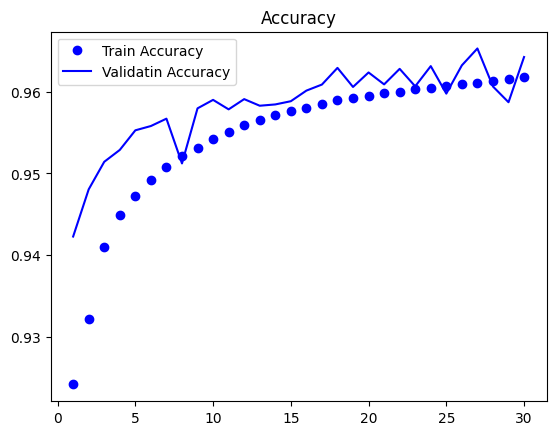

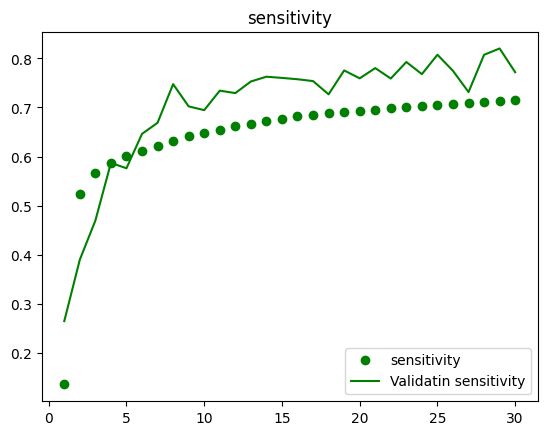

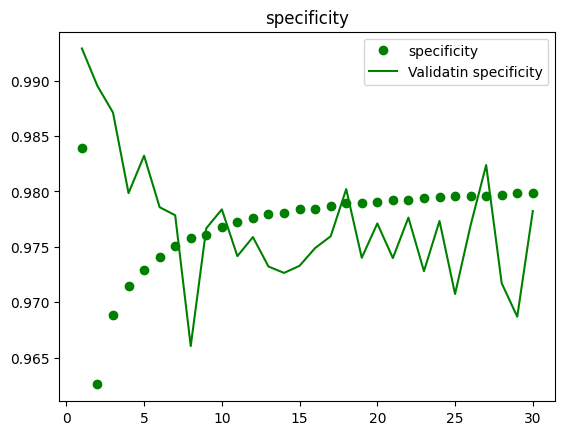

<Figure size 640x480 with 0 Axes>

In [5]:
check_result.plot_history(HISTORY_PATH)

In [3]:
# Define custom objects for loading the model
custom_objects = {'DiceLoss': loss.DiceLoss(), 
                  'sensitivity': metrics.sensitivity,
                  'specificity': metrics.specificity,
                  'accuracy' : metrics.accuracy,
                  'DropBlock2D': sd_unet.DropBlock2D}

test_preproc = preprocess.build_augmentation_for_general(INPUT_SHAPE[0], INPUT_SHAPE[0], is_train=False)
test_generator = data_generator.FullSizedDataGenerator(
    TRAIN_SOURCE, 
    batch_size=2, 
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    is_train=False,
    is_test=True,
    augmentation= test_preproc
)

MODEL_PATH = '/visuworks/Blindless_AIFFELTON/Ablation Study/SD_Unet/model_parameters/sd_unet_30ep_1024_fG_wo_decay.tf/29--0.2470-0.7135-0.9798-0.8202-0.9687.pb'
model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)

metrics.print_evaluation(model, test_generator)

2024-01-31 06:43:04.170990: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


690/690 [==============================] - 110s 156ms/step - loss: 0.2399 - sensitivity: 0.8177 - specificity: 0.9682 - accuracy: 0.9581
Loss: 0.23990637063980103
Sensitivity: 0.8176985383033752
Specificity: 0.9682163596153259
Accuracy: 0.9580562710762024
